## Classification Problem: Seasonal Flu

* Student name: Anthony Warren, Marcelo Scatena, Piotr Czolpik
* Student pace: full time
* Scheduled project review date: 28/01/2021
* Instructor name: Skyler English
***

## Introduction

The goal of this project was to build a classifier to predict whether someone was vaccinated against the seasonal flu or not as accurately as possible. Flu season comes around yearly. Every year people either take the flu shot or they do not. We made splits in Age gaps, genders, children in households, etc to see the statistical side of things before we did the modeling. Also we tried to answer some questions such as which subsets of the population should you target when hoping to increase the total number of people receiving the vaccine each year. Or weather to focus more on the female or male audience, or to focus on what age group.

- In this notebook we'll:
  - Provide recommendations about what could be done to increase the number of vaccinated people
  - Find out which characteristics lead people to be more or less prone to have taken the seasonal flu vaccine 
  - Train and run models that can correctly identify the likelihood that an individual received the seasonal flu vaccine or not

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score,\
                        precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder

RANDOM_SEED = 1235846
import warnings
warnings.filterwarnings("ignore")

## Data

The data at our disposal is from the 2009 National h1n1 flu survey. It can be found [here](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/).

In [2]:
# The data was split between targets and predicators beforehand
features_df = pd.read_csv('./data/flu_training_set_features.csv', index_col='respondent_id')
labels_df = labels_df = pd.read_csv("./data/flu_training_set_labels.csv", index_col="respondent_id")

In [3]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [4]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [5]:
# Train Test split to to have a test set to compare our results to
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=0.25,
    random_state=RANDOM_SEED
)

In [6]:
# The features dropped are coded to not give personal information in the h1n1 survey, so we can't use it for our models
drop_features = ['hhs_geo_region', 'employment_industry','employment_occupation']
X_train.drop(drop_features, axis=1, inplace=True)
X_test.drop(drop_features, axis=1, inplace=True)

# Separate Objects fom Numerical features
numeric_features = [col for col in X_train.columns if X_train[col].dtype != 'O']
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'O']

In [7]:
# Handle missing values of numeric features
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True))]
)
# Handle missing values and perform ohe in categorical features
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent", add_indicator=True)),
          ('ohe', OneHotEncoder(handle_unknown="ignore"))]
)
# Put them both in a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
# Creating simple models to run our data
models = {'Naive_Bayes':
              {'regressor': GaussianNB(),
               'preprocessor': preprocessor},
          'Decision_Trees':
              {'regressor': DecisionTreeClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'KNN':
              {'regressor': KNeighborsClassifier(),
               'preprocessor': preprocessor},
          'Logistic':
              {'regressor': LogisticRegression(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'Random_Forest':
              {'regressor': RandomForestClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'G_Boost':
              {'regressor': GradientBoostingClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor},
          'Hist_Boost':
              {'regressor': HistGradientBoostingClassifier(random_state=RANDOM_SEED),
               'preprocessor': preprocessor}
              }

In [9]:
# Helper function to evaluate models
def model_predictions(model, x_train, y_train, x_test=None, y_test=None):
    '''
    Enter model name, train data, and optionaly test data
    Generate scores for precision, recall, accuracy, and F1 score
    If test data is inputed, display them both,
    If only train data is imputed, siplay only results for train data.
    
    Returns Precision and Accuracy scores, and y hat for train data or,
    if imputed, for the test data.
    '''
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    if x_test is not None:
        y_hat_test = model.predict(x_test)
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('-----')

    print('Training Recall: ', recall_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Recall: ', recall_score(y_test, y_hat_test))
    print('-----')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('-----')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing F1-Score: ', f1_score(y_test, y_hat_test))
    if x_test is not None:
        return precision_score(y_test, y_hat_test), accuracy_score(y_test, y_hat_test), y_hat_test
    return precision_score(y_train, y_hat_train), accuracy_score(y_train, y_hat_train), y_hat_train

In [10]:
# dictionaries to keep track of our initial models performances
precision_dict = {}
accuracy_dict = {}
auc_dict = {}

In [11]:
# Loop through our models, generate model, display scores and save them on dictionaries
for name, model in models.items():  
    print(name)
    X_train_processed = model['preprocessor'].fit_transform(X_train)
    X_test_processed = model['preprocessor'].transform(X_test)
    model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
    print(model)
    precision_dict[name], accuracy_dict[name], y_hat_test = model_predictions(model['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)
    auc_dict[name] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
    print(f'Area under the curve for {name} model: {auc_dict[name]}.')

Naive_Bayes
{'regressor': GaussianNB(), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                                  'opinion_seas_sick_from_vacc',
                                  'hous

## Baseline

In [12]:
# Transform the data to use only 1 column as predicator for baseline model
base_X_train = X_train.copy()
base_X_train.drop(base_X_train.columns.difference(['opinion_seas_risk']), 1, inplace=True)
base_X_test = X_test.copy()
base_X_test.drop(base_X_test.columns.difference(['opinion_seas_risk']), 1, inplace=True)
base_X_train.fillna(value=2, inplace=True)
base_X_test.fillna(value=2, inplace=True)

Baseline
{'Baseline': {'regressor': LogisticRegression(random_state=1235846), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                                  'opinion_seas_sick_from_vacc',
 

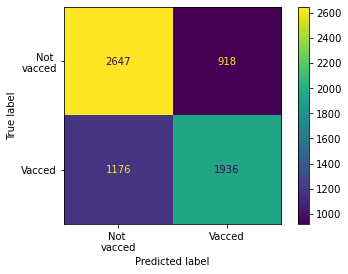

In [13]:
# Use Logistic Regression for baseline model
model_baseline = {'Baseline':
              {'regressor': LogisticRegression(random_state=RANDOM_SEED),
               'preprocessor': preprocessor}}

model = 'Baseline'
print(model)
model_baseline[model]['fit_regressor'] = model_baseline[model]['regressor'].fit(base_X_train, y_train.seasonal_vaccine)
print(model_baseline)
precision_dict[model], accuracy_dict[model], y_hat_test = model_predictions(model_baseline[model]['fit_regressor'], base_X_train, y_train.seasonal_vaccine, base_X_test, y_test.seasonal_vaccine)

auc_dict[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc_baseline = auc_dict[model]
print(f'Area under the curve for {model} model: {auc_baseline}.')

# Create comfusion Matrix of model
cm_baseline = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_baseline, display_labels=['Not \nvacced', 'Vacced']).plot();

Our first metric comparing these new models was the Area Under the Curve metric, which gives us an all around understanding of the model performance

In [14]:
auc_dict

{'Naive_Bayes': 0.685111381721031,
 'Decision_Trees': 0.6751075779590925,
 'KNN': 0.7186408221173433,
 'Logistic': 0.7736578669368359,
 'Random_Forest': 0.7696207414992229,
 'G_Boost': 0.7810228784562856,
 'Hist_Boost': 0.7838412226841219,
 'Baseline': 0.6823022314201553}

In [15]:
auc_lst = [auc for auc in auc_dict.values()]

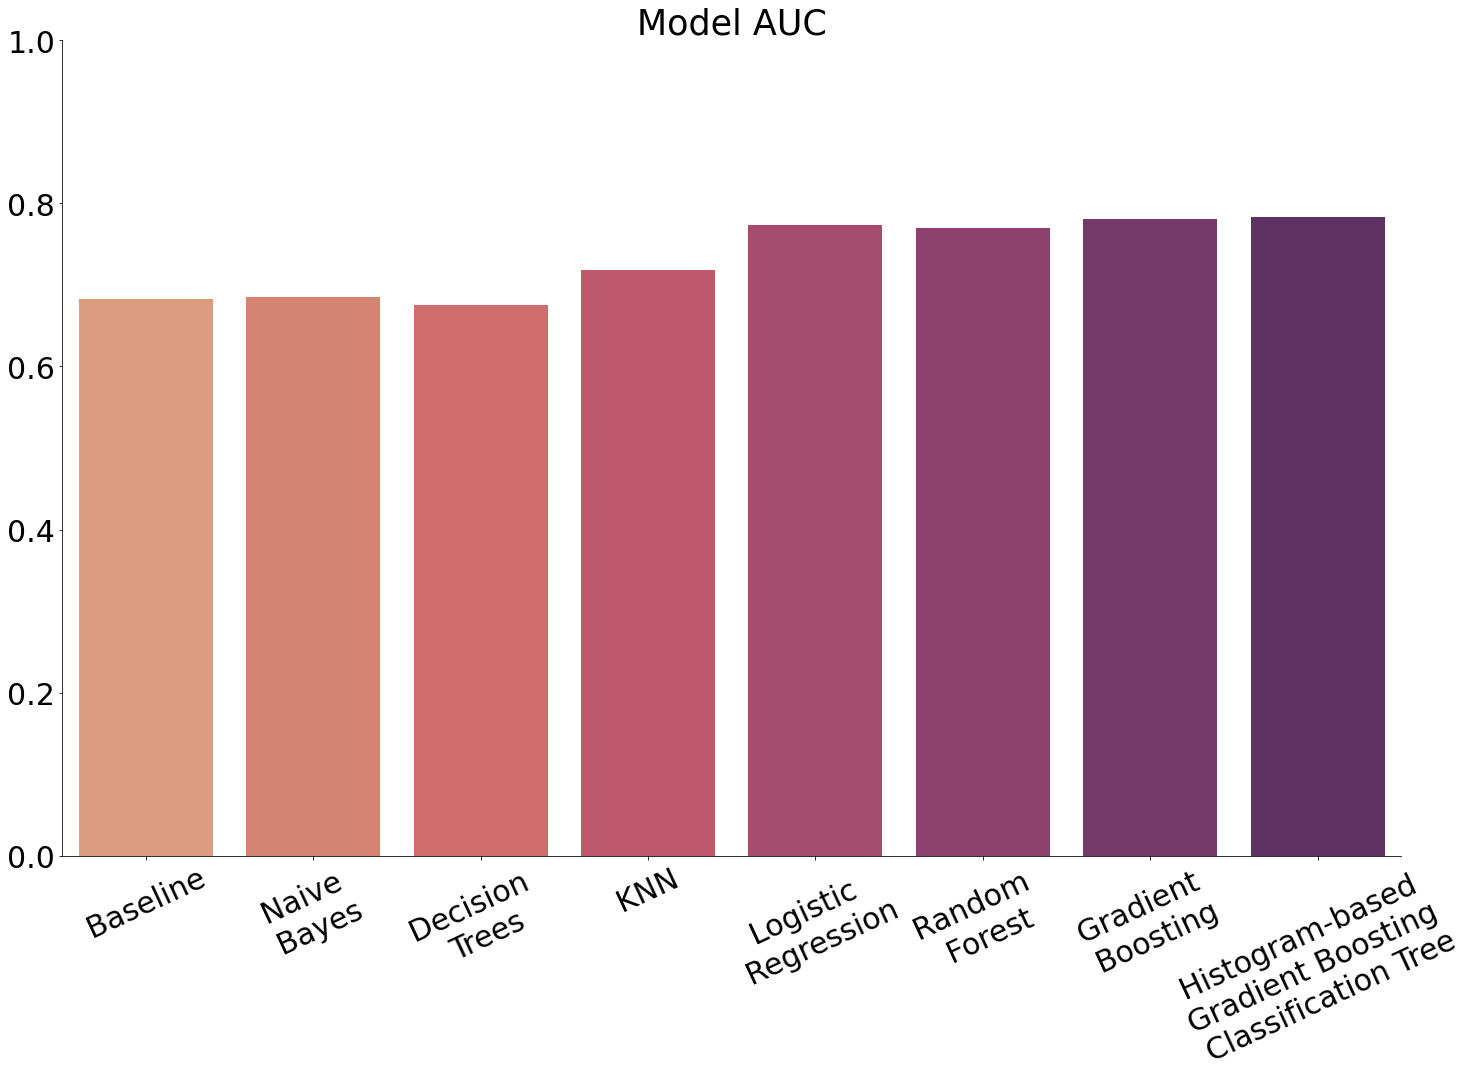

In [16]:
AUC = [auc_lst[7], auc_lst[0], auc_lst[1], auc_lst[2], auc_lst[3], auc_lst[4], auc_lst[5], auc_lst[6]]
names = ['Baseline', 'Naive \nBayes', 'Decision \nTrees', 'KNN', 'Logistic \nRegression', 'Random \nForest', 'Gradient \nBoosting', 'Histogram-based \nGradient Boosting \nClassification Tree']

fig, ax = plt.subplots(figsize=(24, 15))
x_label = names
ax = sns.barplot(x_label, AUC, palette="flare")
plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()
ax.set_ylim(bottom=0, top=1)
ax.set_title('Model AUC', fontsize=35);
# plt.savefig('Skyler_graph_2', bbox_inches='tight');

We can see here that the most advanced models have, even with default paramenters, tend to be more efficient than the older ones. The same is true for Precision and Accuracy as we'll see below.<br />
We chose precision as our main evaluation metric for our models over recall because, given any amount of incorrect predictions, we’d rather focus on the ones where the individual have not received the vaccine but the model predicts they did (false positives) over those the model predicted didn’t receive the vaccines, but did (false negatives). From here on we'll try to generate models with high Precision, but taking into consideration that we don't want our Accuracy to fall below the 72~75% area.

In [17]:
precision_dict

{'Naive_Bayes': 0.6160409556313993,
 'Decision_Trees': 0.6524663677130045,
 'KNN': 0.7075440345629778,
 'Logistic': 0.7748726655348047,
 'Random_Forest': 0.7731322823851954,
 'G_Boost': 0.781683001013856,
 'Hist_Boost': 0.7790311877903119,
 'Baseline': 0.6783461807988788}

In [18]:
accuracy_dict

{'Naive_Bayes': 0.6765014227946683,
 'Decision_Trees': 0.6765014227946683,
 'KNN': 0.7209824771604014,
 'Logistic': 0.7763965852927962,
 'Random_Forest': 0.7726523887973641,
 'G_Boost': 0.7835854425640257,
 'Hist_Boost': 0.785831960461285,
 'Baseline': 0.6863861015426089}

# Model Tuning

We've tuned a few models a few different times because a cross validation search can take a long time to perform given the amount of models it examines and the cross validation strategy. We've used the best results from one search to search for more parameters for another search, when applicable. Models with fewer parameters took less searches.

In [19]:
# New dictionaries for tuned models
precision_dict_tuned = {}
accuracy_dict_tuned = {}
auc_dict_tuned = {}

## Tuning Naive Bayes

In [20]:
# Grid_search for Naive Bayes
pipeline_nb = Pipeline([( "preprocessor" , preprocessor),
                       ("nb",GaussianNB())])

parameters_nb = {'nb__var_smoothing': np.logspace(0,-9, num=10)}

gs_nb=GridSearchCV(pipeline_nb,parameters_nb)

gs_nb.fit(X_train,y_train.seasonal_vaccine)

gs_nb.best_params_

{'nb__var_smoothing': 1.0}

In [21]:
model_nb_tuned = {'Naive Bayes Tuned':
              {'regressor': GaussianNB(var_smoothing=1.0),
               'preprocessor': preprocessor}}

model = 'Naive Bayes Tuned'
print(model)
X_train_processed = model_nb_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_nb_tuned[model]['preprocessor'].transform(X_test)
model_nb_tuned[model]['fit_regressor'] = model_nb_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)

print(model_nb_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_nb_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} model: {auc}.')

Naive Bayes Tuned
{'Naive Bayes Tuned': {'regressor': GaussianNB(var_smoothing=1.0), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                                  'opinion_seas_sick_from_v

## Tuning Decision Trees

In [22]:
# # Grid_search for Decision Trees
# pipeline_dtc = Pipeline([( "preprocessor" , preprocessor),
#                        ("dtc",DecisionTreeClassifier())])

# # Chosing hyperparameters to be tested
# parameters_dtc = {}
# parameters_dtc['dtc__criterion'] = ['gini', 'entropy']
# parameters_dtc['dtc__min_samples_leaf'] = [1, 5, 10]
# parameters_dtc['dtc__max_depth'] = [3, 5, 10, 15, 25]
# parameters_dtc['dtc__max_features'] = [5, 10, 15, 25]
# parameters_dtc['dtc__min_impurity_decrease'] = [0, 0.1, 0.2]

# gs_dtc=GridSearchCV(pipeline_dtc,parameters_dtc)

# gs_dtc.fit(X_train,y_train.seasonal_vaccine)
# # Display best phyperparameters
# gs_dtc.best_params_

In [23]:
# Creating model using tuned paramenters
model_dtc_tuned = {'Decision Tree':
              {'regressor': DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=10, max_features=25),
               'preprocessor': preprocessor}}

model = 'Decision Tree' 
print(model)
X_train_processed = model_dtc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_dtc_tuned[model]['preprocessor'].transform(X_test)
model_dtc_tuned[model]['fit_regressor'] = model_dtc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_dtc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_test_hat = model_predictions(model_dtc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Decision Tree
{'Decision Tree': {'regressor': DecisionTreeClassifier(max_depth=10, max_features=25, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                      

## Tuning Logistic Regression

In [24]:
# # Grid_search for Logistic Regression
# pipeline_lr = Pipeline([( "preprocessor" , preprocessor),
#                        ("lr",LogisticRegression())])

# parameters_lr = {}
# parameters_lr['lr__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# parameters_lr['lr__C'] = [.1, .5, 1, 1.5]
# parameters_lr['lr__solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# gs_lr=GridSearchCV(pipeline_lr,parameters_lr)

# gs_lr.fit(X_train,y_train.seasonal_vaccine)

# gs_lr.best_params_

In [25]:
model_lr_tuned = {'Logistic Regression':
              {'regressor': LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
               'preprocessor': preprocessor}}

model = 'Logistic Regression' 
print(model)
X_train_processed = model_lr_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_lr_tuned[model]['preprocessor'].transform(X_test)
model_lr_tuned[model]['fit_regressor'] = model_lr_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_lr_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_test_hat = model_predictions(model_lr_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Logistic Regression
{'Logistic Regression': {'regressor': LogisticRegression(C=0.1, penalty='l1', solver='liblinear'), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                         

## Tuning Random Forest

In [26]:
# # Grid_search for Random Forest
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier())])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__min_samples_leaf'] = [1, 5, 10]
# parameters_rfc['rfc__max_depth'] = [1, 3, 5, 10, 15, 25]

# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [27]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf=5),
               'preprocessor': preprocessor}}

model = 'Random Forest' 
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_test_hat = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(max_depth=15, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                                  'opini

## Tuning Random Forest #2

In [28]:
# # Grid_search for Random Forest #2
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(criterion='gini', min_samples_leaf=5))])

# parameters_rfc = {}
# parameters_rfc['rfc__max_depth'] = [3, 5]
# parameters_rfc['rfc__ccp_alpha'] = [0, 0.1, 0.5, 1, 2]
# parameters_rfc['rfc__n_estimators'] = [50, 100, 250, 500]


# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [29]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, n_estimators=500),
               'preprocessor': preprocessor}}
 
model = 'Random Forest'
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                       

## Tuning Random Forest #3

In [30]:
# # Randomized_search for Random Forest #3
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(min_samples_leaf=5, max_depth=5, n_estimators=100))])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__max_features'] = [9, 11, 15, 19]

# gs_rfc=RandomizedSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [31]:
model_rfc_tuned = {'Random Forest':
              {'regressor': RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, n_estimators=500, max_features=11),
               'preprocessor': preprocessor}}
 
model = 'Random Forest'
print(model)
X_train_processed = model_rfc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned[model]['preprocessor'].transform(X_test)
model_rfc_tuned[model]['fit_regressor'] = model_rfc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_rfc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')

Random Forest
{'Random Forest': {'regressor': RandomForestClassifier(criterion='entropy', max_depth=5, max_features=11,
                       min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                 

## Tuning Gradient Boosting

In [32]:
# # Grid_search for Gradient Boosting
# pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("gbc",GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))])

# parameters_gbc = {}
# parameters_gbc['gbc__min_samples_leaf'] = [1, 5, 10]
# parameters_gbc['gbc__max_depth'] = [3, 5, 10, 15, 20]

# gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

# gs_gbc.fit(X_train,y_train.seasonal_vaccine)

# gs_gbc.best_params_

Gradient Boosting
{'Gradient Boosting': {'regressor': GradientBoostingClassifier(max_depth=5, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                             

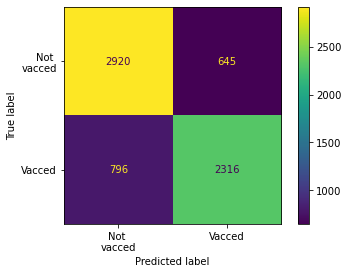

In [33]:
model_gbc_tuned = {'Gradient Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting'
print(model)
X_train_processed = model_gbc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned[model]['preprocessor'].transform(X_test)
model_gbc_tuned[model]['fit_regressor'] = model_gbc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

### Tuning Gradient Boost #2

In [34]:
# # Grid_search for Gradient Boosting #2
# pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("gbc",GradientBoostingClassifier(n_estimators=500, learning_rate=0.1))])

# parameters_gbc = {}
# parameters_gbc['gbc__min_samples_leaf'] = [5, 10]#[1, 5, 10]
# parameters_gbc['gbc__max_depth'] = [3, 5, 10]#, 15, 20]

# gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

# gs_gbc.fit(X_train,y_train.seasonal_vaccine)

# gs_gbc.best_params_

Gradient Boosting 2
{'Gradient Boosting 2': {'regressor': GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
               

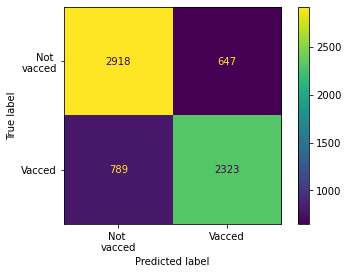

In [35]:
model_gbc_tuned_2 = {'Gradient Boosting 2':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.01),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 2'
print('Gradient Boosting 2')
X_train_processed = model_gbc_tuned_2[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_2[model]['preprocessor'].transform(X_test)
model_gbc_tuned_2[model]['fit_regressor'] = model_gbc_tuned_2[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_2)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_2[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 3
{'Gradient Boosting 3': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=6, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
    

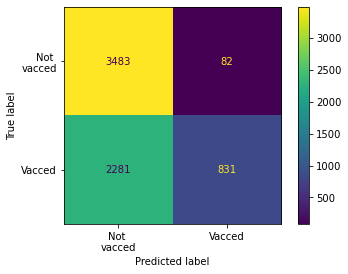

In [36]:
model_gbc_tuned_3 = {'Gradient Boosting 3':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=6, n_estimators=100, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 3'
print(model)
X_train_processed = model_gbc_tuned_3[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_3[model]['preprocessor'].transform(X_test)
model_gbc_tuned_3[model]['fit_regressor'] = model_gbc_tuned_3[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_3)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_3[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 4
{'Gradient Boosting 4': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
              

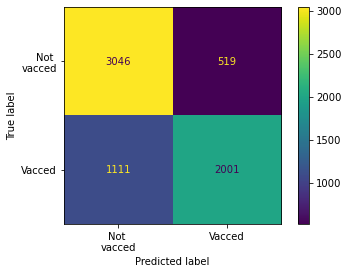

In [37]:
model_gbc_tuned_4 = {'Gradient Boosting 4':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 4'
print(model)
X_train_processed = model_gbc_tuned_4[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_4[model]['preprocessor'].transform(X_test)
model_gbc_tuned_4[model]['fit_regressor'] = model_gbc_tuned_4[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_4)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_4[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Gradient Boosting 5
{'Gradient Boosting 5': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=7, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
              

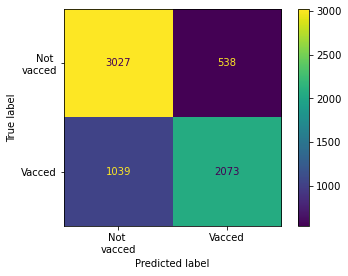

In [38]:
model_gbc_tuned_5 = {'Gradient Boosting 5':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=7, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}

model = 'Gradient Boosting 5'
print(model)
X_train_processed = model_gbc_tuned_5[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned_5[model]['preprocessor'].transform(X_test)
model_gbc_tuned_5[model]['fit_regressor'] = model_gbc_tuned_5[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_gbc_tuned_5)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_gbc_tuned_5[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_gbc, display_labels=['Not \nvacced', 'Vacced']).plot()

## Tuning Hist Boost

In [39]:
# # Grid_search for Hist Boost
# pipeline_hbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("hbc",HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100,))])

# parameters_hbc = {}
# parameters_hbc['hbc__min_samples_leaf'] = [5, 10]
# parameters_hbc['hbc__max_depth'] = [5, 10, 15]

# gs_hbc=GridSearchCV(pipeline_hbc,parameters_hbc)

# gs_hbc.fit(X_train,y_train.seasonal_vaccine)

# gs_hbc.best_params_

Hist Boosting
{'Hist Boosting': {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                                

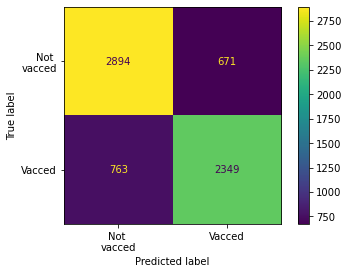

In [40]:
model_hbc_tuned = {'Hist Boosting':
              {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=5),
               'preprocessor': preprocessor}}

model = 'Hist Boosting'
print(model)
X_train_processed = model_hbc_tuned[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned[model]['preprocessor'].transform(X_test)
model_hbc_tuned[model]['fit_regressor'] = model_hbc_tuned[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_hbc_tuned)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_hbc_tuned[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_hbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_hbc, display_labels=['Not \nvacced', 'Vacced']).plot()

Hist Boosting 2
{'Hist Boosting 2': {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_seas_risk',
                            

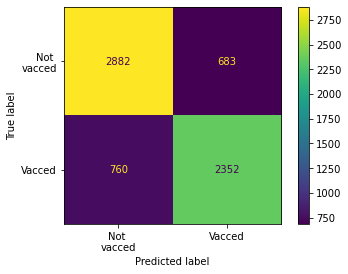

In [41]:
model_hbc_tuned_2 = {'Hist Boosting 2':
              {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10, learning_rate=0.1),
               'preprocessor': preprocessor}}

model = 'Hist Boosting 2'
print(model)
X_train_processed = model_hbc_tuned_2[model]['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned_2[model]['preprocessor'].transform(X_test)
model_hbc_tuned_2[model]['fit_regressor'] = model_hbc_tuned_2[model]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
print(model_hbc_tuned_2)
precision_dict_tuned[model], accuracy_dict_tuned[model], y_hat_test = model_predictions(model_hbc_tuned_2[model]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

auc_dict_tuned[model] = roc_auc_score(y_test.seasonal_vaccine, y_hat_test)
auc = auc_dict_tuned[model]
print(f'Area under the curve for {model} Tuned model: {auc}.')
cm_hbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test)
ConfusionMatrixDisplay(cm_hbc, display_labels=['Not \nvacced', 'Vacced']).plot()

## Final Model decision

Here we examined our models in regards to Precision and Accuracy. We've stipulated we want models with an Accuracy at least higher than 75%, and then with the highest Precision we could reach. We chose those numbers because the models can trade Accuracy for Precision, but with we do that, we have a less efficient model all around. This way we discarded models with low Accuracy, even if they had higher Precision.

In [42]:
precision_dict_tuned

{'Naive Bayes Tuned': 0.6895839480672765,
 'Decision Tree': 0.7443029490616622,
 'Logistic Regression': 0.7738864331859912,
 'Random Forest': 0.7810325887953131,
 'Gradient Boosting': 0.7821681864235056,
 'Gradient Boosting 2': 0.7821548821548822,
 'Gradient Boosting 3': 0.9101861993428259,
 'Gradient Boosting 4': 0.794047619047619,
 'Gradient Boosting 5': 0.7939486786671773,
 'Hist Boosting': 0.7778145695364238,
 'Hist Boosting 2': 0.7749588138385503}

In [43]:
accuracy_dict_tuned

{'Naive Bayes Tuned': 0.7263741201138235,
 'Decision Tree': 0.7522839598622135,
 'Logistic Regression': 0.775198442414258,
 'Random Forest': 0.7638160850681444,
 'Gradient Boosting': 0.7841845140032949,
 'Gradient Boosting 2': 0.7849333533023813,
 'Gradient Boosting 3': 0.6460985472517597,
 'Gradient Boosting 4': 0.7558783884978284,
 'Gradient Boosting 5': 0.7638160850681444,
 'Hist Boosting': 0.7852328890220158,
 'Hist Boosting 2': 0.7838849782836603}

We've selected the Gradient Boosting 4 model as our final model, since it has a more balanced Precision an Accuracy score.

In [44]:
accuracy_v_tuned = [v for v in accuracy_dict_tuned.values()]

In [45]:
precision_v_tuned = [v for v in precision_dict_tuned.values()]

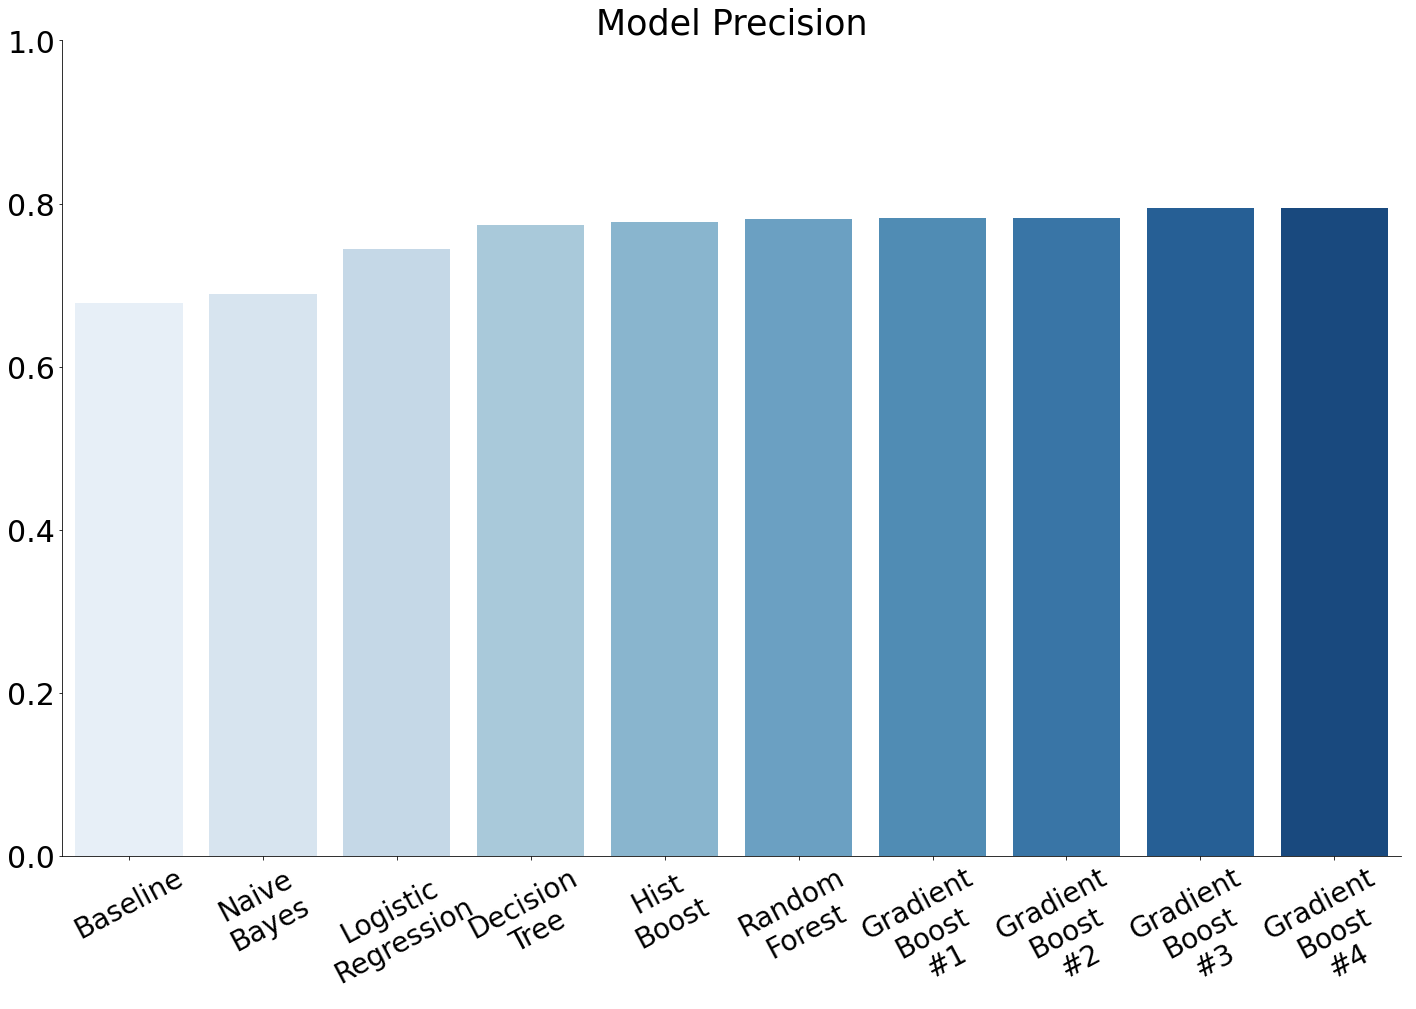

In [58]:
precision = [precision_dict['Baseline'], precision_v_tuned[0], precision_v_tuned[1], precision_v_tuned[2], precision_v_tuned[9], precision_v_tuned[3], precision_v_tuned[4], precision_v_tuned[5], precision_v_tuned[7], precision_v_tuned[8]]
names = ['Baseline', 'Naive\nBayes', 'Logistic\nRegression', 'Decision\nTree', 'Hist\nBoost', 'Random\nForest', 'Gradient\nBoost\n#1', 'Gradient\nBoost\n#2', 'Gradient\nBoost\n#3', 'Gradient\nBoost\n#4']
# accuracy = [accuracy_v_tuned[0], accuracy_v_tuned[1], accuracy_v_tuned[9], accuracy_v_tuned[2], accuracy_v_tuned[3], accuracy_v_tuned[4], accuracy_v_tuned[5], accuracy_v_tuned[6]]#, accuracy_v_tuned[7]]

fig, ax = plt.subplots(figsize=(24, 15))
x_label = names
ax = sns.barplot(x_label, precision, palette="Blues")
# sns.barplot(x_label, accuracy, palette="mako", ax=ax)
plt.xticks(rotation=28, size=28)
plt.yticks(size=30)
sns.despine()
ax.set_ylim(bottom=0, top=1)
ax.set_title('Model Precision', fontsize=35)
# plt.savefig('Skyler_graph', bbox_inches='tight');

In [47]:
# Insert our final model in a pipeline to use it for the Feature Permutation Importance
pipeline_f_i = Pipeline([('preprocessor', preprocessor),
            ('gbc', GradientBoostingClassifier(min_samples_leaf=5, max_depth=7, n_estimators=500, learning_rate=0.001))])
pipeline_f_i.fit(X_test, y_test.seasonal_vaccine)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                         

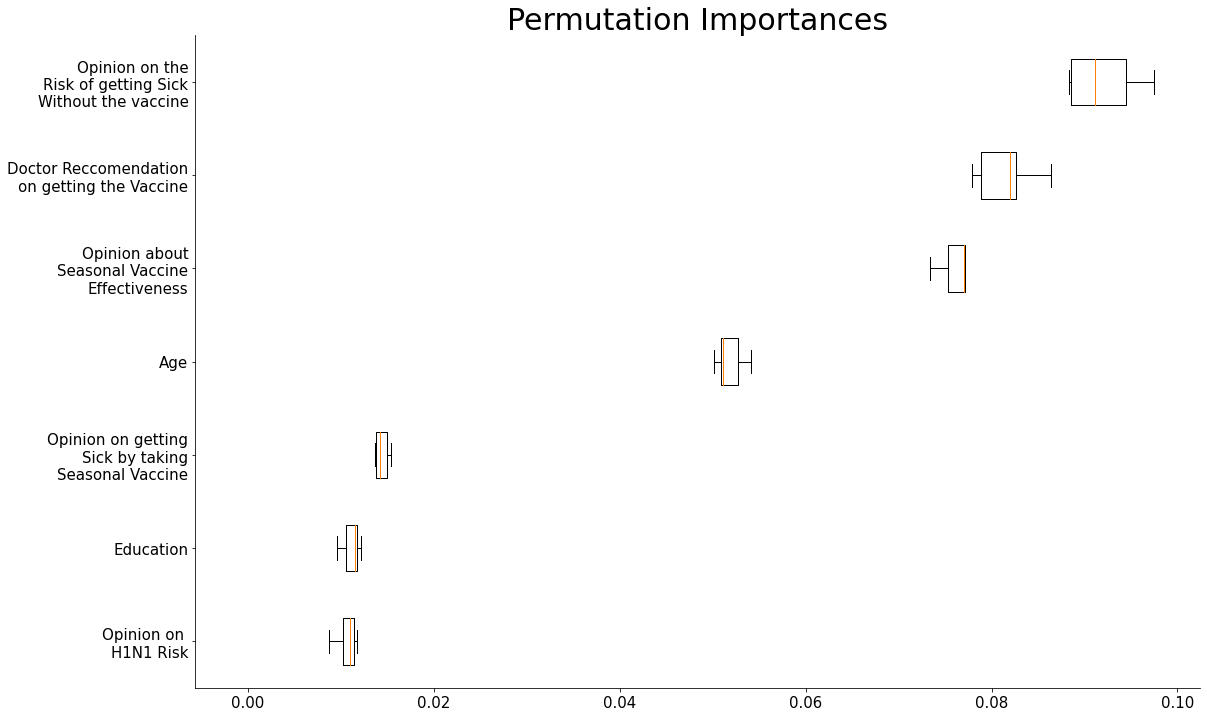

In [48]:
result = permutation_importance(
    pipeline_f_i, X_test, y_test.seasonal_vaccine, n_repeats=10, random_state=RANDOM_SEED, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(18, 12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx], showfliers=False
)

ax.set_title("Permutation Importances", fontsize=30)#20
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine()
# It the 3 following lines of code are commented out, this cell will plot the permutation importance of the whole dataset
ax.set_ylim(bottom=25.5, top=32.5)
labels = [i for i in range(0,25)] + ['Opinion on \nH1N1 Risk', 'Education', 'Opinion on getting\nSick by taking\nSeasonal Vaccine', 'Age', 'Opinion about\nSeasonal Vaccine\nEffectiveness', 'Doctor Reccomendation\non getting the Vaccine', 'Opinion on the\nRisk of getting Sick\nWithout the vaccine']
ax.set_yticklabels(labels);

# plt.savefig('Permutation_Importances2', bbox_inches='tight');

This plot shows us the top seven features ranked by importance by our model. We can clearly see that opinions, which can be translated to level of information, have a very igh impact in predicting our target. That, paired with Doctors Recommendation, form an axis which the Department of Helth can influence with more information, that should lead into higher vaccination turnout.

Since age group is also one of our most important features for predicting wheter an individual has taken the vaccine, we also looked into which percentage each group has taken the vaccine.

In [49]:
complete_df = features_df.join(labels_df, on='respondent_id', how='right', lsuffix='1', rsuffix='2')

In [50]:
complete_df.groupby('age_group')['seasonal_vaccine'].value_counts(normalize=True)

age_group      seasonal_vaccine
18 - 34 Years  0                   0.715436
               1                   0.284564
35 - 44 Years  0                   0.637474
               1                   0.362526
45 - 54 Years  0                   0.598702
               1                   0.401298
55 - 64 Years  1                   0.511235
               0                   0.488765
65+ Years      1                   0.673681
               0                   0.326319
Name: seasonal_vaccine, dtype: float64

In [51]:
perc = [.2845, .3625, .4013, .5112, .6737]

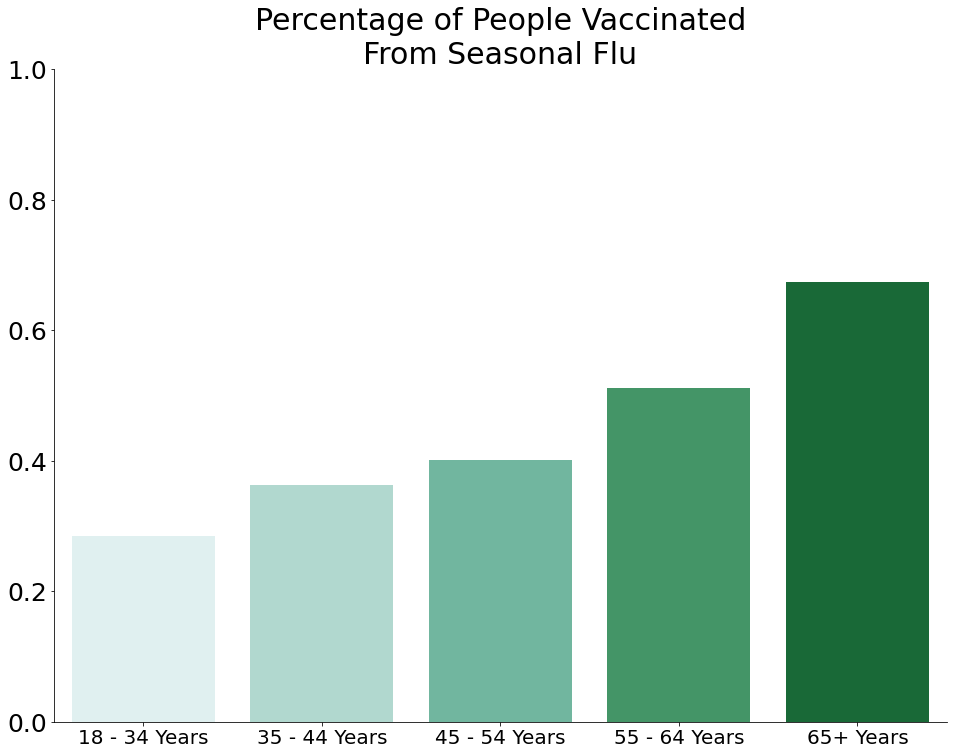

In [52]:
fig, ax = plt.subplots(figsize=(16,12))

sns.barplot(x=['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'],
            y=perc,
            ax = ax, 
            palette="BuGn")
plt.title('Percentage of People Vaccinated\nFrom Seasonal Flu', size=30)
ax.set_ylim(bottom=0, top=1)
plt.xticks(size=20)
plt.yticks(size=25)
sns.despine()
# plt.savefig('Age_group', bbox_inches='tight');

## Recommendations
* Raise awareness of dangers of the seasonal flu via new campaigns to everyone
  - Peoples own opinions about the risks of the flu are highly correlated with them getting the vaccine or not.New campaigns talking about the risks could have a positive effect in vaccination rollout.
* A more specific campaign towards folks aged below their mid thirties could be more beneficial as they are the least likely age groups to be vaccinated
  - People below their mid thirties are the least likely age group to take the seasonal flu vaccine. We reccomend campaings that target that group more specifically, since they'll be targeting a larger non vaccinated audience.
* Have doctors and practitioners reach out to patients to take the vaccine
  - Lastly, people tend to listen to their doctors. We suggest communicating to doctors about proactive campaigns, be it via email or telephone, where practitioners reach out to patients to comunicate the importance of the vaccine.
***